In [ ]:
import TidalPy

# TidalPy.clear_cache()
import numpy as np
import matplotlib.pyplot as plt
from TidalPy.utilities.spherical_helper import calculate_voxel_volumes, calculate_mass_gravity_arrays
from TidalPy.utilities.conversions import days2rads, rads2days, orbital_motion2semi_a

N = 20

orbital_frequency = days2rads(6.0)
spin_frequency = days2rads(3.0)
host_mass = 2e29
planet_mass = 3.7e24
planet_radius = 5.86e6
semi_major_axis = orbital_motion2semi_a(orbital_frequency, host_mass, planet_mass)
eccentricity = 0.1
obliquity = np.radians(45.)

planet_bulk_density = planet_mass / ((4. / 3.) * np.pi * planet_radius**3)

IC_radius = 0.25 * planet_radius
OC_radius = 0.4 * planet_radius

upper_radius_bylayer_array = np.asarray((IC_radius, OC_radius, planet_radius), dtype=np.float64)
radius_array = np.concatenate((
    np.linspace(0.0, IC_radius, N, dtype=np.float64),
    np.linspace(IC_radius, OC_radius, N, dtype=np.float64),
    np.linspace(OC_radius, planet_radius, N, dtype=np.float64)
))

IC_index     = np.zeros(radius_array.size, dtype=bool)
OC_index     = np.zeros(radius_array.size, dtype=bool)
mantle_index = np.zeros(radius_array.size, dtype=bool)
IC_index[np.arange(0, N)]         = True
IC_index[np.arange(N, 2 * N)]     = True
IC_index[np.arange(2 * N, 3 * N)] = True

viscosity_array = np.empty_like(radius_array)
viscosity_array[IC_index] = 1.0e24
viscosity_array[OC_index] = 1.0e12
viscosity_array[mantle_index] = 1.0e22

shear_array = np.empty_like(radius_array)
shear_array[IC_index] = 1.0e11
shear_array[OC_index] = 0.
shear_array[mantle_index] = 5.0e10

bulk_array = np.empty_like(radius_array)
bulk_array[IC_index] = 1.0e12
bulk_array[OC_index] = 1.0e11
bulk_array[mantle_index] = 5.0e10

density_array = np.empty_like(radius_array)
density_array[IC_index] = 10000
density_array[OC_index] = 8000
density_array[mantle_index] = 3500

volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)
longitude_array = np.radians(np.linspace(0., 360., N-1))
colatitude_array = np.radians(np.linspace(0.1, 179.9, N-2))
voxel_volume = calculate_voxel_volumes(radius_array, longitude_array, colatitude_array)

time_domain = np.linspace(0., 86400. * rads2days(orbital_frequency), N+1)
longitude_matrix, colatitude_matrix, time_matrix = np.meshgrid(longitude_array, colatitude_array, time_domain, indexing='ij')

from TidalPy.rheology import Andrade, Elastic, Newton

layer_types = ('solid', 'liquid', 'solid')
is_static_bylayer = (False, True, False)
is_incompressible_bylayer = (False, True, False)
indices_by_layer = (IC_index, OC_index, mantle_index)

from TidalPy.tides.modes.multilayer_modes import collapse_multilayer_modes

Finished first go
Working on TimeIt
10.8 s ± 802 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


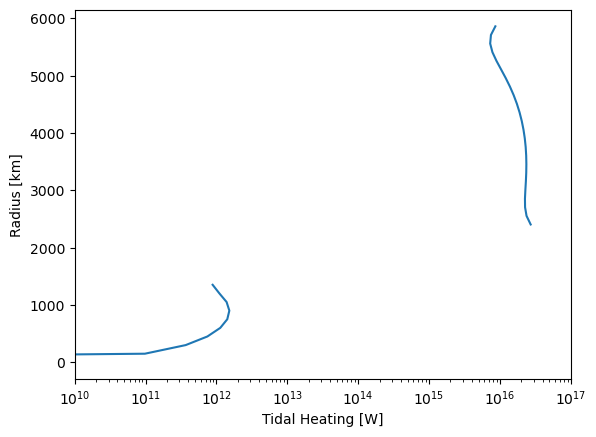

In [ ]:
# SciPy Integrator (N=40)
# Times:
# v0.5.0a - 17.5s, 19.1s
# 15.7s
# 15s, 12.8s, 12.1s
# 10.5s, 11.3s, 10.8s
# CySolver Integrator (v0.6.0)

shear_viscosity_array = viscosity_array
bulk_viscosity_array = viscosity_array
shear_rheology_inst_bylayer = (Elastic(), Newton(), Andrade())
bulk_rheology_inst_bylayer = (Elastic(), Elastic(), Elastic())

out = collapse_multilayer_modes(
    orbital_frequency,
    spin_frequency,
    semi_major_axis,
    eccentricity,
    host_mass,
    planet_bulk_density,
    radius_array,
    density_array,
    bulk_array,
    shear_array,
    bulk_viscosity_array,
    shear_viscosity_array,
    shear_rheology_inst_bylayer,
    bulk_rheology_inst_bylayer,
    upper_radius_bylayer_array,
    longitude_matrix,
    colatitude_matrix,
    time_matrix,
    voxel_volume,
    layer_types,
    is_static_bylayer,
    is_incompressible_bylayer,
    obliquity,
    use_general_obliquity=True,
    solve_load_numbers=False,
    force_mode_calculation=False,
    degree_l=2,
    use_modes=True,
    use_static_potential=False,
    use_simple_potential=False,
    orbit_average_results=True,
    use_kamata=False,
    integration_method='DOP853',
    integration_rtol=1.0e-9,
    integration_atol=1.0e-10,
    verbose=False,
    nondimensionalize=True)
print('Finished first go')

fig, ax = plt.subplots()
ax.plot(np.sum(out[0], axis=(1,2)), radius_array/1000)
ax.set(xscale='log', xlabel='Tidal Heating [W]', ylabel='Radius [km]', xlim=(1e10, 1e17))

print('Working on TimeIt')
%timeit collapse_multilayer_modes(    orbital_frequency,    spin_frequency,    semi_major_axis,    eccentricity,    host_mass,    planet_bulk_density,    radius_array,    density_array,    bulk_array,    shear_array,    bulk_viscosity_array,    shear_viscosity_array,    shear_rheology_inst,    bulk_rheology_inst,    upper_radius_bylayer_array,    longitude_matrix,    colatitude_matrix,    time_matrix,    voxel_volume,    layer_types,    is_static_bylayer,    is_incompressible_bylayer,    obliquity,    use_general_obliquity=True,    solve_load_numbers=False,    force_mode_calculation=False,    degree_l=2,    use_modes=True,    use_static_potential=False,    use_simple_potential=False,    orbit_average_results=True,    use_kamata=False,    integration_method='DOP853',    integration_rtol=1.0e-9,    integration_atol=1.0e-10,    verbose=False,    nondimensionalize=True)
